# Prendre en main l'API Python d'ArcGIS - épisode 5
## Téléchargement automatique, préparation de données, manipulation des SeDF (spatially enabled dataframes) et publication

Dans ce quatrième tutoriel de le **[série de l'été consacrée à la prise en main de l'API Python d'ArcGIS](https://www.codethemap.fr/2024/05/prise-en-main-api-python-arcgis-intro.html)**, nous allons voir ensemble comment tirer parti de l'API pour réaliser des opérations de préparation des données. Nous verrons plusieurs opérations sur les DataFrames pandas, qui permettent de manipuler les données de manière très efficace. Pour gérer les données spatiales, nous apprendrons à utiliser les Spatially Enabled DataFrames, à les utiliser pour de l'analyse spatiale et à les publier en tant que feature layer sur notre portail.  

Notez qu'un compte Creator ou supérieur avec des privilèges de publication de contenu sont nécessaires.
Vous pouvez exécuter ce Notebook directement dans ArcGIS Notebooks sur ArcGIS Online (disponible par défaut si votre administrateur vous a accordé les droits nécessaires), dans ArcGIS Enterprise (disponible avec le rôle serveur correspondant) ou en le téléchargeant et en l'ouvrant sur ArcGIS Pro (plus d'infos [dans la doc](https://pro.arcgis.com/fr/pro-app/latest/arcpy/get-started/pro-notebooks.htm)). Vous pouvez également l'exécuter dans n'importe quel environnement d'exécution de votre choix, mais veillez dans ce cas à [avoir installé les packages nécessaires](https://developers.arcgis.com/python/guide/anaconda/).

### 1/ Connexion au GIS et import des bibliothèques 📚

Nous commençons par importer les différentes bibliothèques nécessaires, puis par nous connecter au SIG. 
Pour cela, nous importons l'objet [`GIS` du module `gis`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#gis), qui représente notre organisation. 
La connexion est ensuite à adapter selon votre environnement et votre méthode d'authentification. [Voir l'aide en ligne pour plus d'informations](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/).  
Si vous êtes connectés en tant qu'admin, la cellule va vous renvoyer un message rouge pour vous prévenir qu'il faut faire attention aux opérations que vous utilisez. Cela n'empêche pas votre code de s'exécuter correctement.

In [1]:
import datetime
import requests
import os
import pandas as pd

from arcgis.gis import GIS

In [2]:
gis = GIS("home")

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:703: UserWarning: You are logged on as plouis_esrifrance with an administrator role, proceed with caution.
  warnings.warn(


#### Alternative pour la connexion si votre environnement n'est pas directement connecté à votre portail

In [ ]:
gis =GIS(
url="https://url.devotre.org/portal",
username="nom_utilisateur",
password="motdepasse"
)

### 2/ Téléchargement des données 📥

Pour ce tutoriel, nous allons utiliser les [données d'historique journalier du compteur de trafic routier de Bordeaux Métropole](https://www.data.gouv.fr/en/datasets/compteur-de-trafic-historique-journalier/#/resources) auxquelles nous accéderons via datagouv.
Ces données sont mises à jour quotidiennement, et contiennent le comptage du nombre de véhicules enregistrés par les différents capteurs placés sur la chaussée à différents endroits de la métropole.  

#### Récupération de la date

Les données mises à jour sont accessibles depuis datagouv durant la journée du lendemain de leur collecte. Afin d'éviter toute erreur selon l'heure à laquelle vous testez ce tutoriel, nous utiliserons pour cet exercice les données d'avant-hier.  
Nous pouvons récupérer la date d'avant-hier grâce à la bibliothèque [`datetime`](https://docs.python.org/fr/3/library/datetime.html) et à ses fonctions [`datetime.now()`](https://docs.python.org/fr/3/library/datetime.html#datetime.datetime.now)et [`timedelta()`](https://docs.python.org/fr/3/library/datetime.html#timedelta-objects). Avec [`strftime()`](https://docs.python.org/fr/3/library/datetime.html#strftime-and-strptime-behavior), nous la formatons selon la forme suivante : AAAA-MM-JJ (ex : 2024-07-04 pour le 4 juillet 2024) car c'est sous ce format que les dates sont enregistrées dans les données auxquelles nous allons accéder.


In [3]:
date_av_hier = (datetime.datetime.now() - datetime.timedelta(days=2)).strftime("%Y-%m-%d")
date_av_hier

'2024-07-28'

#### Création d'un dossier cible et téléchargement des données

Dans la cellule suivante, nous définissons une fonction qui nous permet de créer un dossier et qui a comme paramètre le nom du dossier que nous allons créer.  
Nous appelons la fonction en passant en argument le nom que nous souhaitons donner à notre dossier, qui va venir ici chercher dynamiquement la date d'avant-hier récupérée ci-dessus.  
Si vous utilisez ArcGIS Notebooks, notez que cette fonction vient des extraits de code organisés par Esri auxquels vous avez accès dans votre environnement :  
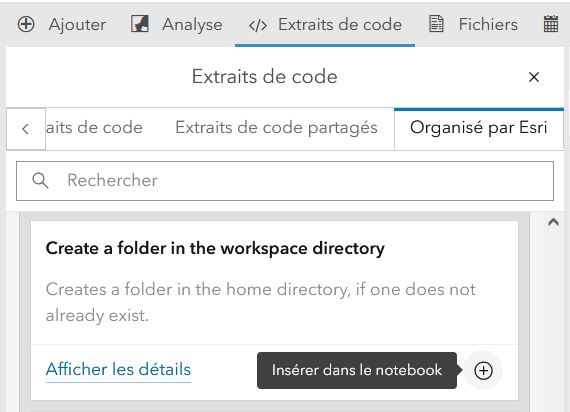

In [4]:
def creation_dossier(nom_dossier: str) -> None:
    home_path = os.path.abspath('/arcgis/home')
    chemin_dossier = os.path.join(home_path, nom_dossier)
    if not os.path.exists(chemin_dossier):
        os.makedirs(chemin_dossier)
        print(f"Dossier créé: {chemin_dossier}")
    else:
        print(f"Le dossier {nom_dossier} existe déjà dans {chemin_dossier}.")
    return(chemin_dossier)

#création du dossier 
chemin_dossier = creation_dossier(f'donnees_comptage_bordeaux_{date_av_hier}')
print(chemin_dossier)

Le dossier donnees_comptage_bordeaux_2024-07-28 existe déjà dans /arcgis/home/donnees_comptage_bordeaux_2024-07-28.
/arcgis/home/donnees_comptage_bordeaux_2024-07-28


Le dossier est maintenant créé et prêt à accueillir nos données. Je créée une nouvelle fonction qui me permet de télécharger des données à partir d'un url. Je récupère pour cela l'adresse à laquelle je retrouve le CSV des données de comptage sur datagouv :  
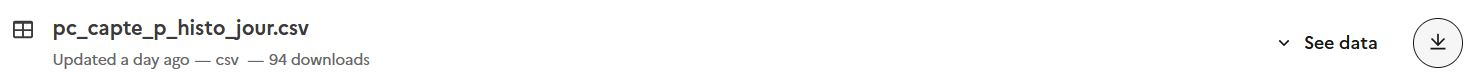  
Après exécution de la fonction, je peux retrouver la donnée téléchargée directement dans le dossier que j'ai créé juste avant.

In [ ]:
def telechargement_donnees(dossier_cible):
    
    nom_donnee = "donnees_comptage_bordeaux.csv"
    url = "https://www.data.gouv.fr/fr/datasets/r/a36dd980-94f6-423f-8bb5-6d92404d3e4e"
        
    print(f"Téléchargement du fichier {nom_donnee} depuis {url}...")
        
    req = requests.get(url, allow_redirects=True)
    url_content = req.content
    csv_file = open(f'{dossier_cible}//{nom_donnee}', 'wb')
    csv_file.write(url_content)
    csv_file.close()
    print(f"Le fichier {nom_donnee} a été téléchargé")

#téléchargement du fichier en utilisant la fonction créée
telechargement_donnees(chemin_dossier)

L'URL à laquelle les données sont disponibles étant stable, ce genre de fonction peut être utilisée pour automatiser la mise à jour quotidienne de données et d'applications. Nous verrons ce genre de workflow plus en détail la semaine prochaine.  
En attendant, je vous propose de regarder un peu plus en détail ce que contiennent les données et comment nous pouvons les nettoyer et les préparer avant de les publier sur notre portail.

### 3/ Lecture en DataFrame pandas 🐼 

La donnée que nous avons téléchargée est au format CSV. Nous allons désormais la convertir en [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), car cette structure de données offre plusieurs avantages en termes de facilité de manipulation et de transformation des données.  
Nous utilisons pour cela la fonction [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) de la bibliothèque [`pandas`](https://pandas.pydata.org/pandas-docs/stable/index.html) (que nous avions importée dans la première cellule de ce Notebook), puis nous affichons le DataFrame dans le Notebook afin de voir à quoi ressemblent nos données.

In [5]:
df_trafic_bordeaux = pd.read_csv(os.path.join(chemin_dossier, "donnees_comptage_bordeaux.csv"),sep = ";", low_memory = False) 
df_trafic_bordeaux

,time,gid,ident,zone,type,comptage_5m,geo_point_2d,cdate
0,2023-09-11,222,Z18CT13,18,BOUCLE,3.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
1,2023-09-12,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
2,2023-09-19,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
3,2023-09-20,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
4,2023-09-21,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
...,...,...,...,...,...,...,...,...
156380,2023-12-09,67,Z1704CT9,17,BOUCLE,6164.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156381,2023-12-16,67,Z1704CT9,17,BOUCLE,6657.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156382,2023-12-23,67,Z1704CT9,17,BOUCLE,5938.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156383,2023-12-24,67,Z1704CT9,17,BOUCLE,3891.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00


### 4/ Préparation et nettoyage des données 🧹

Nous allons maintenant voir ensemble plusieurs opérations sur les DataFrames afin de préparer les données avant leur publication.

#### Suppression des valeurs manquantes (NaN)

Une première bonne pratique en terme de nettoyage de données est de supprimer les valeurs manquantes (NaN), qui peuvent générer plusieurs problèmes lorsque vous souhaiterez analyser vos données. Pour cela, pandas possède la méthode [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) :

In [6]:
df_trafic_na = df_trafic_bordeaux.dropna()
df_trafic_na

,time,gid,ident,zone,type,comptage_5m,geo_point_2d,cdate
0,2023-09-11,222,Z18CT13,18,BOUCLE,3.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
1,2023-09-12,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
2,2023-09-19,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
3,2023-09-20,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
4,2023-09-21,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
...,...,...,...,...,...,...,...,...
156380,2023-12-09,67,Z1704CT9,17,BOUCLE,6164.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156381,2023-12-16,67,Z1704CT9,17,BOUCLE,6657.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156382,2023-12-23,67,Z1704CT9,17,BOUCLE,5938.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156383,2023-12-24,67,Z1704CT9,17,BOUCLE,3891.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00


Vous devriez maintenant avoir un nombre d'enregistrements légèrement inférieur.

#### Renommage des colonnes et suppression des colonnes inutiles

Le jeu de données que nous utilisons possède des noms de colonnes très propres : pas d'espace, pas d'accents, pas de caractères spéciaux ou exotiques. C'est très important, car sinon vous pourriez rencontrer plusieurs problèmes une fois vos données publiées. Cependant, ce n'est malheureusement pas toujours le cas. Je vais donc vous montrer comment renommer les colonnes, ici en donnant des nom un peu plus parlants.  
Pandas possède une fonction [`rename()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html), dans laquelle je passe simplement en argument un dictionnaire contenant en clés les noms actuels des colonnes que je souhaite renommer et en valeurs les nouveaux noms :

In [7]:
df_trafic_colonnes = df_trafic_na.rename(columns={'time': 'date', 'ident': 'identifiant','geo_point_2d':'lat_long'})
df_trafic_colonnes

,date,gid,identifiant,zone,type,comptage_5m,lat_long,cdate
0,2023-09-11,222,Z18CT13,18,BOUCLE,3.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
1,2023-09-12,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
2,2023-09-19,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
3,2023-09-20,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
4,2023-09-21,222,Z18CT13,18,BOUCLE,0.0,"44.7791829, -0.6111968",2012-11-08T15:24:12+00:00
...,...,...,...,...,...,...,...,...
156380,2023-12-09,67,Z1704CT9,17,BOUCLE,6164.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156381,2023-12-16,67,Z1704CT9,17,BOUCLE,6657.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156382,2023-12-23,67,Z1704CT9,17,BOUCLE,5938.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00
156383,2023-12-24,67,Z1704CT9,17,BOUCLE,3891.0,"44.8071253, -0.6007774",2012-11-19T17:19:04+00:00


Lorsque l'on manipule des jeux de données de taille relativement importante, nous pouvons essayer de les réduire afin d'en améliorer les performances. Une manière très simple d'arriver à cela est de supprimer les colonnes dont nous n'avons pas besoin pour nos analyses ou pour identifier nos données.  
Nous utilisons la fonction [`drop()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) afin de supprimer 3 colonnes de notre dataframe, dont nous passons les labels en argument de la fonction sous forme de liste. Le paramètre `axis` permet de choisir si l'on supprime des lignes (0) ou des colonnes (1).

In [8]:
df_trafic_drop_colonnes = df_trafic_colonnes.drop(['gid', 'type','cdate'], axis=1)
df_trafic_drop_colonnes

,date,identifiant,zone,comptage_5m,lat_long
0,2023-09-11,Z18CT13,18,3.0,"44.7791829, -0.6111968"
1,2023-09-12,Z18CT13,18,0.0,"44.7791829, -0.6111968"
2,2023-09-19,Z18CT13,18,0.0,"44.7791829, -0.6111968"
3,2023-09-20,Z18CT13,18,0.0,"44.7791829, -0.6111968"
4,2023-09-21,Z18CT13,18,0.0,"44.7791829, -0.6111968"
...,...,...,...,...,...
156380,2023-12-09,Z1704CT9,17,6164.0,"44.8071253, -0.6007774"
156381,2023-12-16,Z1704CT9,17,6657.0,"44.8071253, -0.6007774"
156382,2023-12-23,Z1704CT9,17,5938.0,"44.8071253, -0.6007774"
156383,2023-12-24,Z1704CT9,17,3891.0,"44.8071253, -0.6007774"


#### Filtre selon la date

La donnée que nous avons téléchargé contient tout un historique de données de comptage routier. Ce qui nous intéresse, c'est les données d'avant-hier. Nous allons donc filtrer notre dataframe en fonction d'un filtre sur la colonne date, où nous garderons uniquement les lignes pour lesquelles la colonne date est égale à la valeur contenue dans la variable `date_av_hier` calculée au début du Notebook :

In [9]:
df_av_hier = df_trafic_drop_colonnes[df_trafic_drop_colonnes['date'] == date_av_hier]
df_av_hier

,date,identifiant,zone,comptage_5m,lat_long
491,2024-07-28,Z6CT5,6,2742.0,"44.8407057, -0.5928835"
883,2024-07-28,Z6CT14,6,1289.0,"44.8424901, -0.5897733"
1024,2024-07-28,Z6CT13,6,1766.0,"44.842193, -0.5934232"
1166,2024-07-28,Z6CT19,6,4815.0,"44.8395507, -0.6078614"
1312,2024-07-28,Z6CT8,6,0.0,"44.8385652, -0.6181598"
...,...,...,...,...,...
154373,2024-07-28,Z29CT10,29,0.0,"44.8469571, -0.5119886"
154636,2024-07-28,Z29CT13,29,1136.0,"44.8473575, -0.5101398"
154898,2024-07-28,Z29CT14,29,1977.0,"44.8536075, -0.5099547"
155667,2024-07-28,Z17CT6,17,4912.0,"44.8020646, -0.5936051"


Voici un petit peu plus d'explications sur comment fonctionne le filtrage d'un DataFrame :  
    `df_trafic_drop_colonnes['date'] == date_av_hier` crée une série de valeurs booléennes (True ou False), où chaque élément est True si la valeur dans la colonne date est égale à la variable `date_av_hier` et False sinon.
`df_trafic_drop_colonnes[df_trafic_drop_colonnes['date'] == date_av_hier]` utilise cette série de booléens pour filtrer `df_trafic_drop_colonnes`, ne gardant que les lignes où la condition est True. En d'autres termes, seules les lignes dont la date correspond à `date_av_hier` sont conservées.  
Nous assignons ce DataFrame filtré dans la nouvelle variable `df_av_hier`.

#### Tri par valeur décroissante

Enfin, nous allons trier notre dataframe selon des valeurs de comptage décroissante, de manière à faire apparaître en premier les capteurs ayant enregistré le plus de trafic. Nous utilisons la méthode [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) en indiquant la colonne sur laquelle nous appliquons le tri, ainsi que l'ordre de tri (`ascending = False` permet d'obtenir un ordre décroissant).  
Je me permets aussi d'imprimer une fraction du DataFrame, ici uniquement les 5 premiers enregistrements grâce à la méthode [`head()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) (à l'inverse, [`tail()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.tail.html) permet d'imprimer uniquement les 5 derniers).

In [10]:
df_trafic_final = df_av_hier.sort_values(by=['comptage_5m'],ascending=False)
df_trafic_final.head()

,date,identifiant,zone,comptage_5m,lat_long
100645,2024-07-28,Z17CT9,17,34313.0,"44.7959917, -0.6033196"
132386,2024-07-28,Z14CT9,14,22521.0,"44.8739855, -0.5651702"
81590,2024-07-28,Z2CT9,2,20001.0,"44.8349387, -0.573224"
107334,2024-07-28,Z14CT7,14,13484.0,"44.8683337, -0.5699995"
106239,2024-07-28,Z26CT1,26,12250.0,"44.812543, -0.5593751"


Nos données sont maintenant prêtes pour la suite !

### 5/ Transformation d'un dataframe en spatially enabled dataframe 📍

 Alors pour l'instant, tout ce qu'on a vu pourrait aussi bien s'appliquer à des géographiques qu'à données de modélisation financières, et les vrais géographes parmi vous sont peut-être en train de ronger leur frein et de se demander quand est-ce que je vais enfin vous montrer des cartes. Respirez un coup, on y arrive !    
Avec l'API Python d'ArcGIS, il est possible de transformer les DataFrames classiques en Spatially Enabled Dataframes si ceux-ci possèdent des informations de latitude et de longitude. Cela va nous permettre ensuite d'utiliser pleinement la composante spatiale de nos données.

#### Création de deux colonnes latitude et longitude

Afin de pouvoir transformer un df en sedf, nous devons pouvoir accéder à deux colonnes distinctes contenant la longitude et la latitude. Pour l'instant, nos données ne possèdent qu'une seule colonne stockant ces deux valeurs séparées par une virgule.  
Nous allons transformer notre dataframe pour qu'il corresponde aux prérequis. La méthode `str.split()` permet de séparer la chaîne contenant latitude et longitude, et nous passons la virgule en argument afin qu'elle soit utilisée comme délimitateur. `expand = True` indique que chaque élément résultant de cette division (ici, la latitude et la longitude) doit être stocké dans une colonne séparée. Nous assignons ces valeurs à deux nouvelles colonnes se nommant latitude et longitude.

In [11]:
df_trafic_final[['latitude', 'longitude']] = df_trafic_final['lat_long'].str.split(',', expand=True)
df_trafic_final

,date,identifiant,zone,comptage_5m,lat_long,latitude,longitude
100645,2024-07-28,Z17CT9,17,34313.0,"44.7959917, -0.6033196",44.7959917,-0.6033196
132386,2024-07-28,Z14CT9,14,22521.0,"44.8739855, -0.5651702",44.8739855,-0.5651702
81590,2024-07-28,Z2CT9,2,20001.0,"44.8349387, -0.573224",44.8349387,-0.573224
107334,2024-07-28,Z14CT7,14,13484.0,"44.8683337, -0.5699995",44.8683337,-0.5699995
106239,2024-07-28,Z26CT1,26,12250.0,"44.812543, -0.5593751",44.812543,-0.5593751
...,...,...,...,...,...,...,...
57872,2024-07-28,Z4CT11,4,0.0,"44.8429215, -0.5862632",44.8429215,-0.5862632
58526,2024-07-28,Z4CT16,4,0.0,"44.8459513, -0.5775646",44.8459513,-0.5775646
112311,2024-07-28,Z7CT6,7,0.0,"44.8409159, -0.642669",44.8409159,-0.642669
59868,2024-07-28,Z22CT13,22,0.0,"44.8667967, -0.5091879",44.8667967,-0.5091879


Les valeurs de latitude et de longitude doivent être de type numérique `float`, hors elles sont pour l'instant de type `object` (c'est en fait un `string` spécifique à pandas). Cela est facilement vérifiable en accédant à la propriété [`dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) du DataFrame, qui renvoie le type de donnée de chaque colonne : 

In [12]:
df_trafic_final.dtypes

date            object
identifiant     object
zone             int64
comptage_5m    float64
lat_long        object
latitude        object
longitude       object
dtype: object

Heureusement, nous pouvons très facilement convertir le format avec la méthode [`astype()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) :

In [13]:
df_trafic_final['latitude'] = df_trafic_final['latitude'].astype(float)
df_trafic_final['longitude'] = df_trafic_final['longitude'].astype(float)

Nous pouvons vérifier que cela a bien fonctionné :

In [14]:
df_trafic_final.dtypes

date            object
identifiant     object
zone             int64
comptage_5m    float64
lat_long        object
latitude       float64
longitude      float64
dtype: object

#### Transformation en SeDF

Notre DataFrame est prêt à être converti en Spatial enabled Dataframe. Dans l'API Python d'ArcGIS, tout ce qui touche aux SeDF est géré par la classe [`GeoAccessor`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#geoaccessor), à laquelle nous accédons dans le code avec le point d'accès `.spatial`.   
Nous utilisons la méthode [`from_xy()`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_xy) du GeoAccessor, dans laquelle nous passons en argument le dataframe à convertir, la colonne x contenant la longitude, la colonne y contenant la latitude et le wikd contenant la référence spatiale :

In [15]:
sedf_trafic = pd.DataFrame.spatial.from_xy(df=df_trafic_final, x_column='longitude', y_column='latitude', sr=4326)
sedf_trafic.head()

,date,identifiant,zone,comptage_5m,lat_long,latitude,longitude,SHAPE
100645,2024-07-28,Z17CT9,17,34313.0,"44.7959917, -0.6033196",44.795992,-0.603320,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.6..."
132386,2024-07-28,Z14CT9,14,22521.0,"44.8739855, -0.5651702",44.873986,-0.565170,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
81590,2024-07-28,Z2CT9,2,20001.0,"44.8349387, -0.573224",44.834939,-0.573224,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
107334,2024-07-28,Z14CT7,14,13484.0,"44.8683337, -0.5699995",44.868334,-0.569999,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
106239,2024-07-28,Z26CT1,26,12250.0,"44.812543, -0.5593751",44.812543,-0.559375,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."


Vous pouvez voir qu'une nouvelle colonne SHAPE a été ajoutée au DataFrame, qui nous permet d'accéder aux informations géographiques de notre donnée, et donc de l'afficher sur une carte ou de réaliser des opérations d'analyses spatiales dessus.  
Nous pouvons vérifier quel type de géométrie (point, polyligne, polygone) possède notre donnée en appelant la propriété [`geometry_type`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.geometry_type) :

In [16]:
sedf_trafic.spatial.geometry_type

['point']

Notez que grâce aux capacités de géocodage d'ArcGIS, il est possible de convertir un DataFrame en Spatially enabled DataFrame directement grâce à une colonne contenant uniquement une adresse avec la méthode [`from_df()`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_df), si par exemple vous ne possédez pas les coordonnées X et Y précises.

### 6/ Affichage du SeDF sur une carte 🌍

Maintenant que nous avons un SeDF, nous pouvons très facilement l'afficher sur une carte. Commençons par créer une carte dans le Notebook [comme nous avons appris à le dans le tutoriel précédent](https://www.codethemap.fr/2024/07/api-python-arcgis-contenu-creation-publication-partage-carte.html) :

In [18]:
carte1 = GIS().map("Bordeaux",11)
carte1

MapView(layout=Layout(height='400px', width='100%'))

La méthode [`plot()`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.plot) du SeDF me permet ensuite d'afficher mes données très facilement sur la carte que je viens de créer en passant la carte en argument :

In [20]:
sedf_trafic.spatial.plot(carte1)

True

Vous devriez voir cela sur votre carte :  
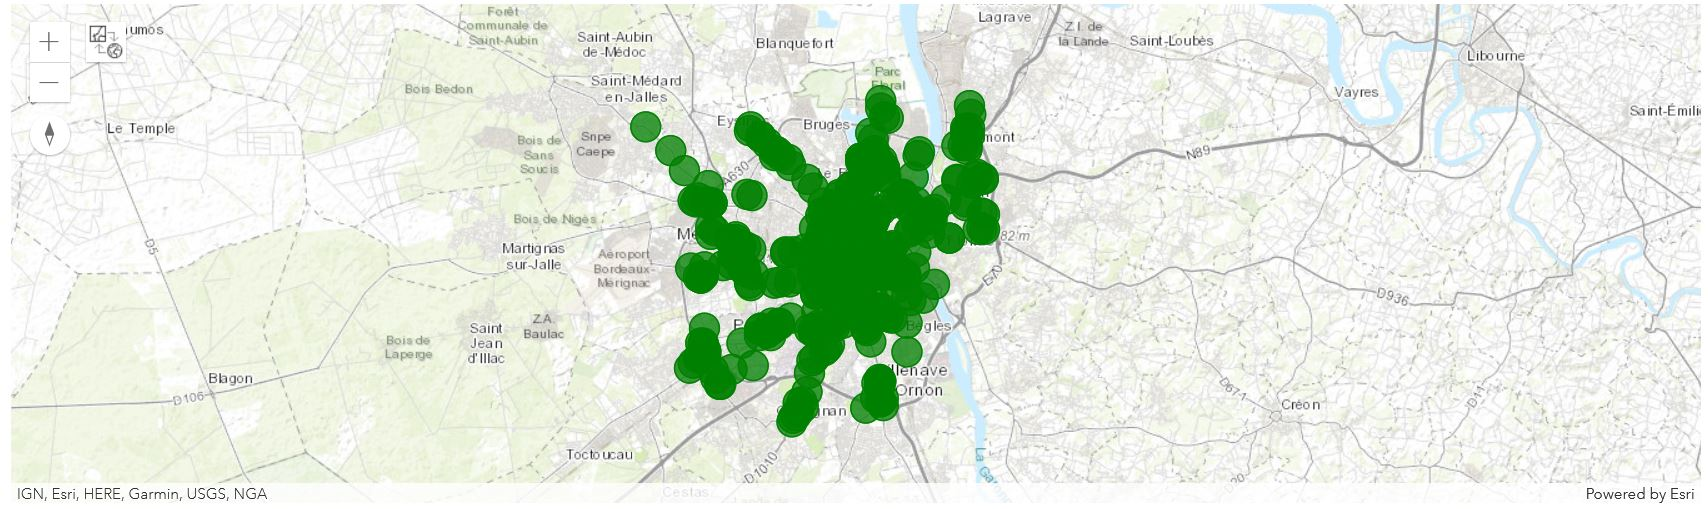

### 7/ Création d'un SeDF à partir d'un feature layer du portail 

Nous avons vu comment créer un SeDF à partir d'un DataFrame, mais sachez qu'il est également possible de lire d'autres formats de données : des feature layers publiés sur le portail (méthode [`from_layer`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_layer)), des classes d'entités (méthode [`from_featureclass`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_featureclass)), depuis une table ([`from_table`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_table)) ou encore depuis des données parquet ([`from_parquet`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_parquet)) et des GeoDatFrame Geopandas ([`from_geodataframe`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_geodataframe)).  
Voyons ensemble comment récupérer une couche d'entités (feature layer) publiée sur le portail et la lire en SeDF.

#### Recherche du feature layer

De la même manière que dans le tutoriel précédent, nous utilisons la fonction `search()` de l'API Python d'ArcGIS pour rechercher un feature layer sur notre portail, et nous récupérons le premier item retourné par la liste.  
Ici, je recherche une couche d'entités contenant les limites administratives de la commune de Bordeaux.   
- *Si vous êtes utilisateur ArcGIS Online*, vous y aurez également accès grâce au paramètre `outside_org`.   
- *Si vous êtes utilisateur ArcGIS Enterprise*, vous devrez publier votre propre couche d'entités hébergées, par exemple à partir des données mises à disposition par l'open data de Bordeaux Métropole, que vous pouvez télécharger [ici](https://opendata.bordeaux-metropole.fr/explore/dataset/fv_commu_s/export/), en sélectionnant uniquement Bordeaux avant la publication. Vous devrez ensuite modifier l'id de la requête pour qu'il corresponde à celui de votre item publié.

<Item title:"Limites commune Bordeaux" type:Feature Layer Collection owner:plouis_esrifrance>
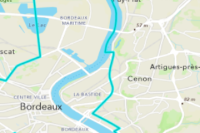

In [21]:
recherche_bdx = gis.content.search("id:20faac07e4944217a43d84734360b84d",outside_org = True)
bdx = recherche_bdx[0]
bdx

#### Lecture du feature layer en SeDF

Grâce à la méthode méthode [`from_layer`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.from_layer), il est maintenant très facile de lire cette couche d'entités en tant que SeDF. En argument de celle-ci, nous passons l'item du feature layer récupéré juste au-dessus. Il faut préciser l'index de la couche en accédant à la propriété `layers` du feature layer (0 pour la première couche, 1 si on souhaite accéder à la deuxième, etc). 

In [22]:
sedf_bdx = pd.DataFrame.spatial.from_layer(bdx.layers[0])
sedf_bdx

,OBJECTID,gid,geom_err,ident,nom,insee,cdate,mdate,georef,Shape__Area,Shape__Length,SHAPE
0,1,18,,063,Bordeaux,33063,1992-03-10 17:18:00+00:00,2022-09-08 14:42:15+00:00,fr_80_33063,0.005676,0.463779,"{""rings"": [[[-0.535528200166254, 44.8891454997..."


Nous pouvons réaccéder au type de géométrie, et constatons qu'il s'agit cette fois-ci d'un polygone.

In [23]:
sedf_bdx.spatial.geometry_type

['polygon']

#### Affichage sur la carte

Ajoutons ce nouvel SeDF à la carte du dessus :

In [25]:
sedf_bdx.spatial.plot(carte1)

True

Voici ce que vous devez voir apparaître :  
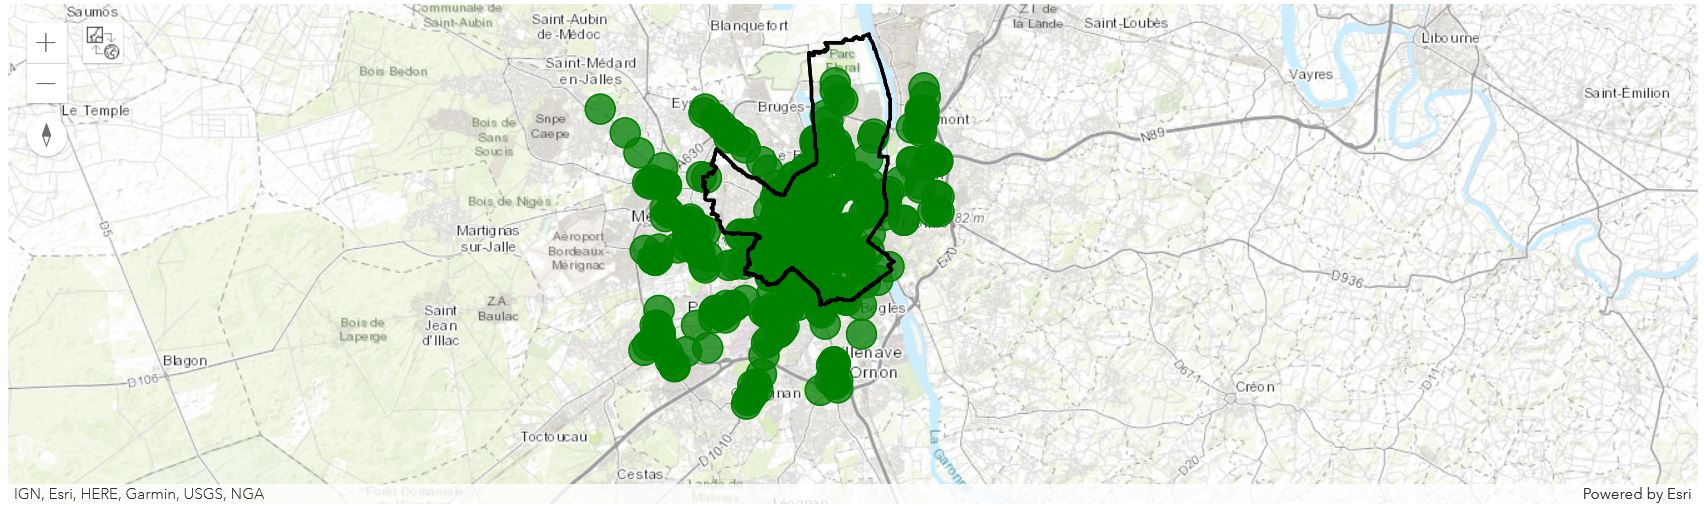

### 8/ Analyse spatiale à partir de deux SeDF 🧪

Nous allons chercher à récupérer uniquement les compteurs situés à l'intérieur de la commune de Bordeaux. Pour cela, nous allons faire une analyse spatiale très basique en comparant la géométrie des limites de la commune à la géométrie des points contenant l'emplacement des compteurs.

#### Accès à la géométrie du SeDF d'emprise de la commune

Nous commençons par accéder à la géométrie de la commune. Pour cela, nous sélectionnons la première (et seule) ligne du SeDF avec [`iloc[0]`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html), puis accédons à sa colonne `SHAPE` qui contient la géométrie de notre donnée. 

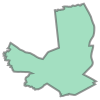

In [26]:
geom_bdx = sedf_bdx.iloc[0].SHAPE
geom_bdx

Selon l'interface dans laquelle vous travaillez, la cellule vous renverra soit un tracé de la géométrie (image de gauche), soit la liste contenant les coordonnées de tous les sommets de la géométrie (image de droite). Il s'agit du même objet.  
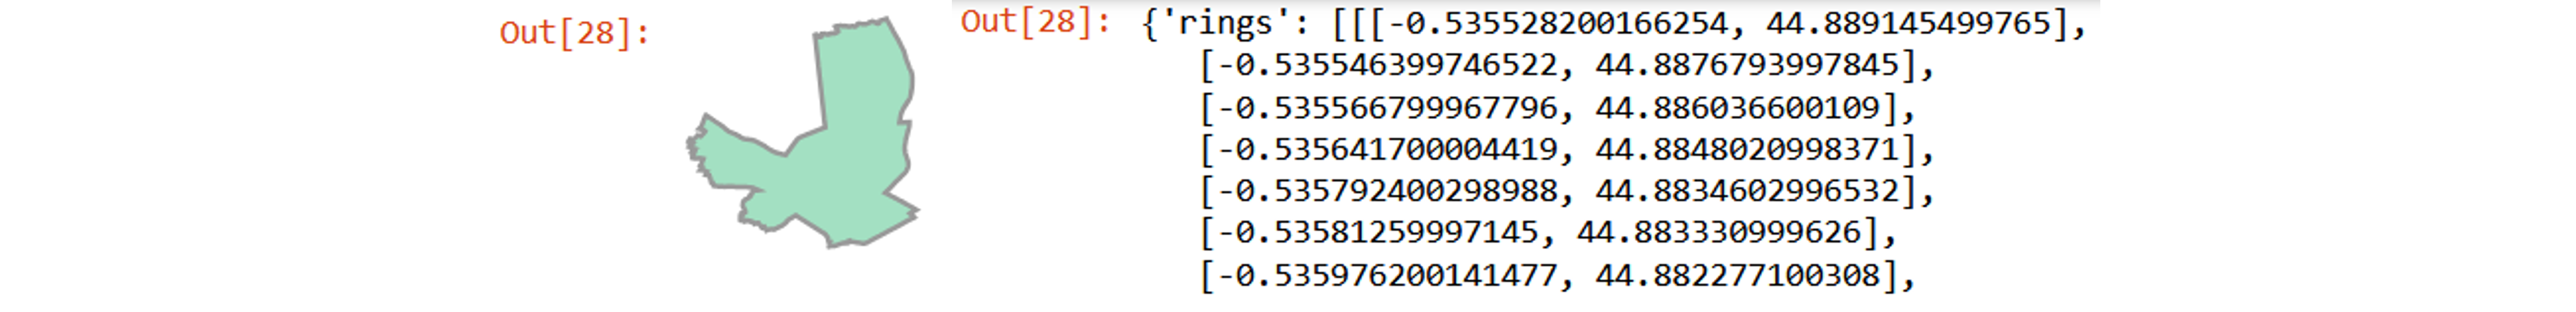

#### Requête sur le SeDF de trafic selon la géométrie des contours de la commune

La classe [`GeoSeriesAccessor`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#geoseriesaccessor) nous permet de réaliser des opérations en utilisant la géométrie des sedf. On y accède dans le code avec l'accesseur `.geom` appliqué à la colonne `SHAPE` du sedf.  
Pour un exemple simple, nous pouvons par exemple utiliser la propriété `centroid` du `GeoSeriesAccessor` pour obtenir le centroïde du polygone représentant la commune de Bordeaux :

In [ ]:
sedf_bdx.SHAPE.geom.centroid

Plutôt sympa mais... ça ne sert à rien pour notre tutoriel ! Donc revenons à nos moutons, et utilisons le [`GeoSeriesAccessor`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#geoseriesaccessor) pour quelque chose de plus utile.  
La méthode [`disjoint()`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoSeriesAccessor.disjoint) permet de comparer deux géométries, et renvoie une série de booléens : `True` si les sont géométries des entités comparées sont disjointes (ne s'intersectent pas) et `False` sinon (les données s'intersectent). J'utilise donc cette méthode sur le sedf contenant les compteurs, et passe en argument la géométrie du sedf contenant les limites de bordeaux récupérée au-dessus.  
`== False` me permet ensuite d'inverser le résultat, et de passer à `True` les géométries non disjointes et à `False` les géométries disjointes.

In [27]:
requete = sedf_trafic.SHAPE.geom.disjoint(geom_bdx) == False
requete

100645    False
132386     True
81590      True
107334     True
106239     True
          ...  
57872      True
58526      True
112311    False
59868     False
53195     False
Name: disjoint, Length: 408, dtype: bool

J'utilise ensuite cette série booléenne pour filtrer le dataframe des compteurs de trafic. En passant la série en entrée de la propriété [`loc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) de mon dataframe, j'accède uniquement aux lignes pour lesquelles la valeur du booléen est `True`. La fonction `copy()` permet de créer une copie du dataframe filtré, afin d'éviter les problèmes liés à la modification d'une vue sur l'original.

In [28]:
sedf_trafic_bdx_only = sedf_trafic.loc[requete].copy()
sedf_trafic_bdx_only

,date,identifiant,zone,comptage_5m,lat_long,latitude,longitude,SHAPE
132386,2024-07-28,Z14CT9,14,22521.0,"44.8739855, -0.5651702",44.873986,-0.565170,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
81590,2024-07-28,Z2CT9,2,20001.0,"44.8349387, -0.573224",44.834939,-0.573224,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
107334,2024-07-28,Z14CT7,14,13484.0,"44.8683337, -0.5699995",44.868334,-0.569999,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
106239,2024-07-28,Z26CT1,26,12250.0,"44.812543, -0.5593751",44.812543,-0.559375,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
140949,2024-07-28,Z5CT22,5,11968.0,"44.8319901, -0.5592043",44.831990,-0.559204,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
...,...,...,...,...,...,...,...,...
117569,2024-07-28,Z9CT11,9,0.0,"44.8332866, -0.6018416",44.833287,-0.601842,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.6..."
54444,2024-07-28,Z25CT7,25,0.0,"44.8777497, -0.5689157",44.877750,-0.568916,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
56283,2024-07-28,Z13CT15,13,0.0,"44.8539933, -0.5889454",44.853993,-0.588945,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."
57872,2024-07-28,Z4CT11,4,0.0,"44.8429215, -0.5862632",44.842922,-0.586263,"{""spatialReference"": {""wkid"": 4326}, ""x"": -0.5..."


#### Vérification des résultats sur une carte

Nous créons une seconde carte, sur laquelle nous allons afficher le nouvel SeDF contenant uniquement les points dans la commune de Bordeaux, ainsi que le SeDF contenant les limites administratives de la ville. Cela nous permet de vérifier que la sélection spatiale a bien fonctionné :

In [29]:
carte2 = GIS().map("Bordeaux",12)
carte2

MapView(layout=Layout(height='400px', width='100%'))

In [32]:
sedf_trafic_bdx_only.spatial.plot(carte2)
sedf_bdx.spatial.plot(carte2)

True

Le résultat final ressemble à cela :  
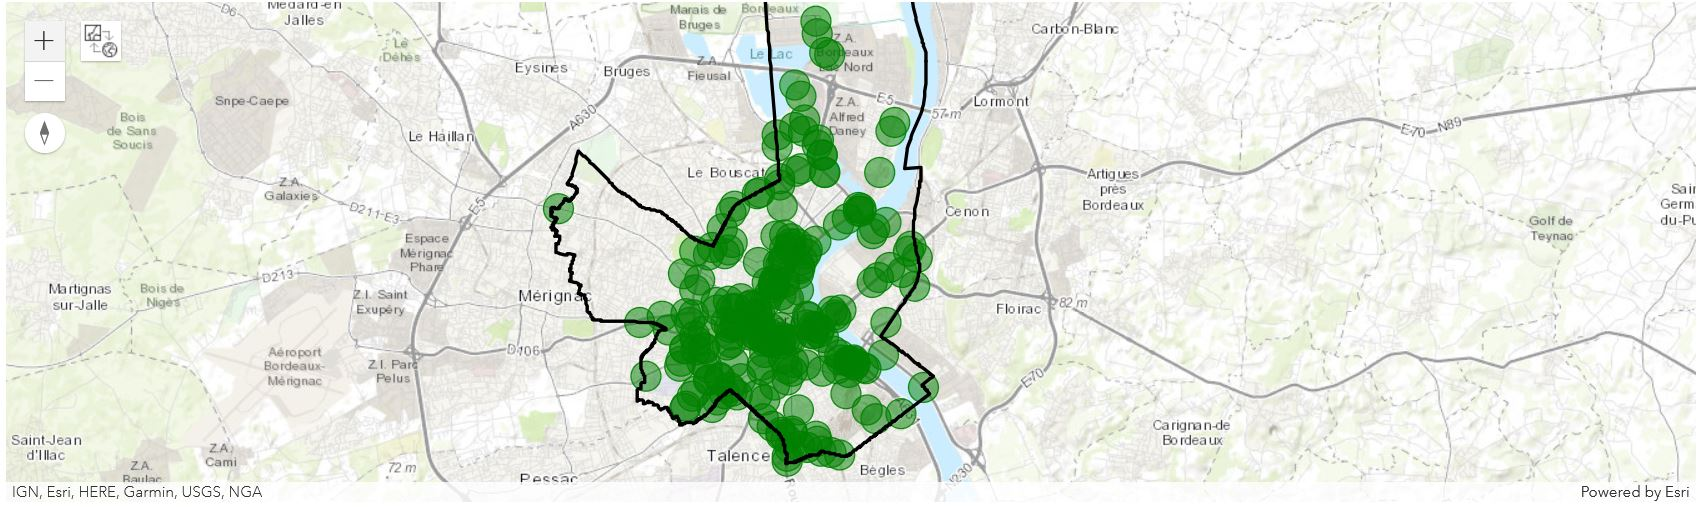

Parfait, ça fonctionne, on est content.

### 9/ Publication du SeDF en tant que feature layer sur le portail 📰

La dernière étape consiste à publier notre sedf en tant que Feature Layer sur le portail. Pour cela, je peux très simplement utiliser la méthode [`to_featurelayer`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.to_featurelayer) du [`GeoAccessor`](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#geoaccessor). Je donne un titre et des tags à mon feature layer, et je réindique la variable de connexion à mon SIG. Le paramètre `sanitize_columns` me permet de m'assurer que les noms de colonnes sont bien des chaînes de caractères, que les caractères invalides seront retirés, etc., si j'ai loupé quelque chose pendant le nettoyage de mes données.

In [31]:
elt_publi = sedf_trafic_bdx_only.spatial.to_featurelayer(title = "comptage_bordeaux", 
                                            gis=gis, 
                                            tags = "comptage, bordeaux", 
                                            sanitize_columns = True)
elt_publi

<Item title:"comptage_bordeaux" type:Feature Layer Collection owner:plouis_esrifrance>

Dans le prochain tutoriel, nous verrons comment intégrer ces opérations de préparation et publication des données dans un workflow plus global de mise à jour de données et de cartes, toujours avec l'API Python d'ArcGIS.